In [1]:
import warnings
warnings.filterwarnings("ignore")

# imports best practice pandas
import os

import numpy as np
import pandas as pd
import missingno as msno
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white", palette=None)
%matplotlib inline
import math
import pickle
import joblib
import dill
import gzip
import inspect

#--------------------------------------------------------

# imports best practice sklearn
import sklearn
from sklearn.feature_selection import VarianceThreshold
from sklearn import set_config

# preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder, RobustScaler, MinMaxScaler
from scipy import stats
from imblearn.over_sampling import RandomOverSampler

# transformers
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import FunctionTransformer

# evaluacion
from sklearn.metrics import mean_absolute_error, r2_score, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
set_config(transform_output = "pandas")

# models
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

# interpretabilidad
import shap

### Importamos el dataset y revisamos las métricas principales

In [2]:
DATA_PATH = "../../data/processed/"
FILE_NAME = "df_capstone_newFeatures.pkl.gz"
PICKLE_PATH = DATA_PATH+FILE_NAME

with gzip.open(PICKLE_PATH, 'rb') as gz_csv_df:

    df_capstone_clean = pd.read_pickle(gz_csv_df)

print('Dataframe cargado exitosamente')

Dataframe cargado exitosamente


In [3]:
DATA_PATH = "../../data/processed/"
FILE_NAME = "df_cluestering_WITH_CLUSTERS.pkl.gz"
PICKLE_PATH = DATA_PATH+FILE_NAME

with gzip.open(PICKLE_PATH, 'rb') as df_load:
    df_capstone_clean_with_clusters = pd.read_pickle(df_load)
    
print('Dataframe cragado exitosamente')

Dataframe cragado exitosamente


In [4]:
def report_df(df, verbose = True):
    '''
    Hace un report simple sobre el DataFrame suministrado.
    '''
    print(df.info(verbose = verbose, show_counts=True))
    total_nulos = df.isnull().sum().sum()
    print()
    print(f"Tenemos un total de {total_nulos} nulos")

In [5]:
report_df(df_capstone_clean)

df_capstone_clean.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5962924 entries, 1479563 to 5679912
Data columns (total 77 columns):
 #   Column                             Non-Null Count    Dtype         
---  ------                             --------------    -----         
 0   pk_cid                             5962924 non-null  int64         
 1   pk_partition                       5962924 non-null  datetime64[ns]
 2   entry_date                         5962924 non-null  datetime64[ns]
 3   entry_channel                      5962924 non-null  object        
 4   active_customer                    5962924 non-null  int64         
 5   segment                            5962924 non-null  object        
 6   short_term_deposit                 5962924 non-null  int64         
 7   loans                              5962924 non-null  int64         
 8   mortgage                           5962924 non-null  int64         
 9   funds                              5962924 non-null  int64         
 10  secur

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,...,nr_risk_high,percent_risk_low,percent_risk_medium,percent_risk_high,risk_index_absolute,life_stage_indicator,customer_lifetime_value_partition,customer_lifetime_value_cumsum,months_from_last_purchase,date_last_purchase
1479563,15891,2018-07-28,2018-07-28,KAT,1,02 - PARTICULARES,0,0,0,0,...,0,0.111111,0.0,0.0,1,Adulto,10.0,10.0,0,2018-07-28
2168122,15891,2018-08-28,2018-07-28,KAT,0,02 - PARTICULARES,0,0,0,0,...,0,0.000000,0.0,0.0,0,Adulto,-10.0,0.0,1,2018-07-28
2962973,16063,2018-11-28,2018-11-19,KAT,1,02 - PARTICULARES,0,0,0,0,...,0,0.000000,0.0,0.0,0,Adulto,0.0,0.0,0,2018-11-28
3628236,16063,2018-12-28,2018-11-19,KAT,1,02 - PARTICULARES,0,0,0,0,...,0,0.000000,0.0,0.0,0,Adulto,0.0,0.0,1,2018-11-28
4028169,16063,2019-01-28,2018-11-19,KAT,1,02 - PARTICULARES,0,0,0,0,...,0,0.000000,0.0,0.0,0,Adulto,0.0,0.0,2,2018-11-28


In [6]:
report_df(df_capstone_clean_with_clusters)

df_capstone_clean_with_clusters.head().T

<class 'pandas.core.frame.DataFrame'>
Index: 5962924 entries, 0 to 5962923
Data columns (total 21 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   pk_cid                     5962924 non-null  int64         
 1   pk_partition               5962924 non-null  datetime64[ns]
 2   segment                    5962924 non-null  object        
 3   age                        5962924 non-null  int64         
 4   financial_health_score     5962924 non-null  float64       
 5   total_profit_customer      5962924 non-null  float64       
 6   months_from_last_purchase  5962924 non-null  int64         
 7   product_mix_diversity      5962924 non-null  float64       
 8   nr_financing_60            5962924 non-null  int64         
 9   nr_invest_savings_40       5962924 non-null  int64         
 10  nr_account_10              5962924 non-null  int64         
 11  nr_debt                    5962924 non-nul

,0,1,2,3,4
pk_cid,15891,15891,16063,16063,16063
pk_partition,2018-07-28 00:00:00,2018-08-28 00:00:00,2018-11-28 00:00:00,2018-12-28 00:00:00,2019-01-28 00:00:00
segment,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES
age,59,59,62,62,62
financial_health_score,0.001671,0.001671,0.001765,0.001765,0.001765
total_profit_customer,0.0,0.0,0.0,0.0,0.0
months_from_last_purchase,0,1,0,1,2
product_mix_diversity,0.083333,0.0,0.0,0.0,0.0
nr_financing_60,0,0,0,0,0
nr_invest_savings_40,0,0,0,0,0


In [7]:
# mergeamos las columnas que necesitamos del df original con todas las variables y dropeamos nr_product_gap_to_max

df_capstone_clean_with_clusters = pd.merge(left = df_capstone_clean_with_clusters,
                                            right = df_capstone_clean[['pk_cid', 'pk_partition','active_customer', 'entry_date', 'regions_ca_id', 'nr_financing_60_trend', 'salary', 'product_mix_diversity']],
                                            how = 'left',
                                            left_on = ['pk_cid', 'pk_partition'],
                                            right_on = ['pk_cid', 'pk_partition'])

df_capstone_clean_with_clusters.drop('nr_product_gap_to_max', axis='columns', inplace=True)
df_capstone_clean_with_clusters.drop('total_profit_customer', axis='columns', inplace=True)
df_capstone_clean_with_clusters.drop('nr_debt', axis='columns', inplace=True)

In [8]:
del df_capstone_clean

In [9]:
report_df(df_capstone_clean_with_clusters)

df_capstone_clean_with_clusters.head().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 24 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   pk_cid                     5962924 non-null  int64         
 1   pk_partition               5962924 non-null  datetime64[ns]
 2   segment                    5962924 non-null  object        
 3   age                        5962924 non-null  int64         
 4   financial_health_score     5962924 non-null  float64       
 5   months_from_last_purchase  5962924 non-null  int64         
 6   product_mix_diversity_x    5962924 non-null  float64       
 7   nr_financing_60            5962924 non-null  int64         
 8   nr_invest_savings_40       5962924 non-null  int64         
 9   nr_account_10              5962924 non-null  int64         
 10  nr_product_trend           5962924 non-null  float64       
 11  customer_tenure            5962924 no

,0,1,2,3,4
pk_cid,15891,15891,16063,16063,16063
pk_partition,2018-07-28 00:00:00,2018-08-28 00:00:00,2018-11-28 00:00:00,2018-12-28 00:00:00,2019-01-28 00:00:00
segment,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES
age,59,59,62,62,62
financial_health_score,0.001671,0.001671,0.001765,0.001765,0.001765
months_from_last_purchase,0,1,0,1,2
product_mix_diversity_x,0.083333,0.0,0.0,0.0,0.0
nr_financing_60,0,0,0,0,0
nr_invest_savings_40,0,0,0,0,0
nr_account_10,1,0,0,0,0


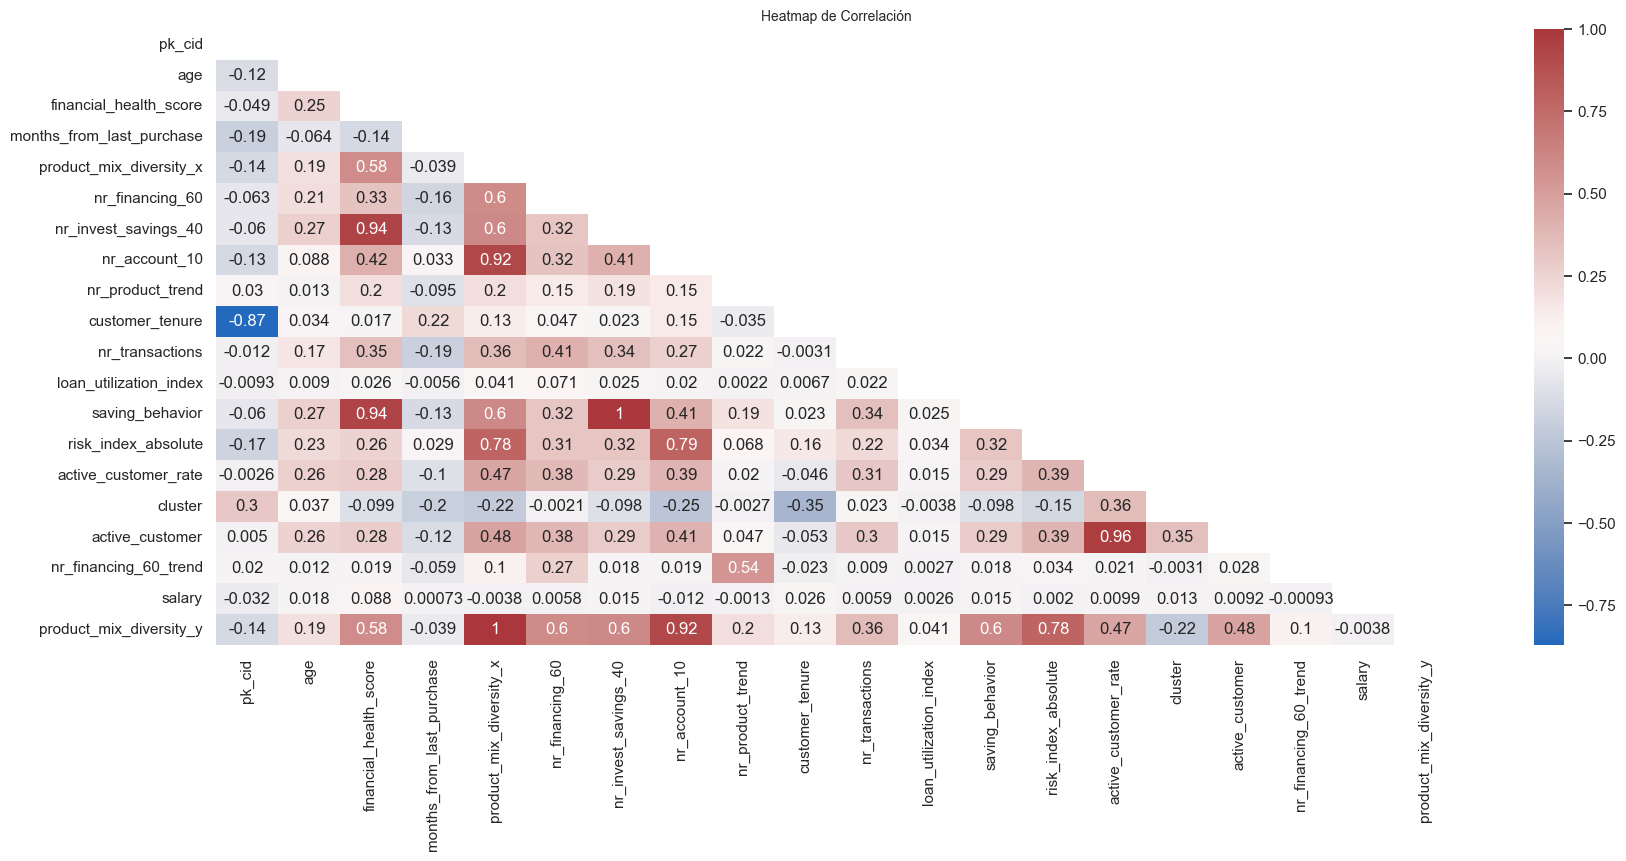

In [10]:
plt.rcParams['figure.figsize'] = (20, 8)

corr = df_capstone_clean_with_clusters.corr(numeric_only=True)
matrix = np.triu(corr)

sns.heatmap(corr, annot=True, cmap="vlag", mask=matrix)
plt.title('Heatmap de Correlación', fontsize = 10)
plt.show()

In [11]:
products_list = ['short_term_deposit', 'loans', 'mortgage', 'funds',
                'securities', 'long_term_deposit', 'em_account_pp', 'credit_card', 'payroll', 'pension_plan',
                'payroll_account', 'emc_account', 'debit_card', 'em_account_p', 'em_acount']

accounts_list = ['em_acount','em_account_p','em_account_pp','emc_account']
saving_and_investment_products_list = ['short_term_deposit','long_term_deposit','funds','pension_plan','securities']
financing_products_list = ['loans','mortgage','credit_card','payroll','payroll_account','debit_card']

if len(products_list) - (len(accounts_list) + len(saving_and_investment_products_list) + len(financing_products_list)) == 0:
    print('Todos los productos incluídos en la lista de productos')
else:
    print('Chequear, algunos productos no están catalogados')

Todos los productos incluídos en la lista de productos


In [12]:
df_capstone_clean_with_clusters_2 = df_capstone_clean_with_clusters.copy()

In [13]:
# dropeamos las variables de productos individuales

try:
    for i in products_list:
        df_capstone_clean_with_clusters_2.drop(i, axis='columns', inplace=True)
except:
    print('No hay columnas de productos a dropear')

No hay columnas de productos a dropear


### Creación de variables para propensión

In [14]:
df_capstone_clean_with_clusters_2.sample(5).head().T

,5927562,1822529,5478802,1533873,4303566
pk_cid,1533426,1146258,1459980,1116342,1339198
pk_partition,2019-03-28 00:00:00,2018-03-28 00:00:00,2018-09-28 00:00:00,2018-08-28 00:00:00,2019-03-28 00:00:00
segment,02 - PARTICULARES,02 - PARTICULARES,03 - UNIVERSITARIO,03 - UNIVERSITARIO,02 - PARTICULARES
age,35,34,20,28,54
financial_health_score,0.001465,0.00249,0.001542,0.001503,0.00295
months_from_last_purchase,0,2,0,7,14
product_mix_diversity_x,0.083333,0.138889,0.083333,0.083333,0.083333
nr_financing_60,0,1,0,0,0
nr_invest_savings_40,0,0,0,0,0
nr_account_10,1,1,1,1,1


In [15]:
df_capstone_clean_with_clusters_2.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 24 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   pk_cid                     5962924 non-null  int64         
 1   pk_partition               5962924 non-null  datetime64[ns]
 2   segment                    5962924 non-null  object        
 3   age                        5962924 non-null  int64         
 4   financial_health_score     5962924 non-null  float64       
 5   months_from_last_purchase  5962924 non-null  int64         
 6   product_mix_diversity_x    5962924 non-null  float64       
 7   nr_financing_60            5962924 non-null  int64         
 8   nr_invest_savings_40       5962924 non-null  int64         
 9   nr_account_10              5962924 non-null  int64         
 10  nr_product_trend           5962924 non-null  float64       
 11  customer_tenure            5962924 no

In [16]:
# creamos el target (si compra en m+1), generico para incluír las otras familias de productos
# comentar y descomentar como sea necesario

df_capstone_clean_with_clusters_2['increased_nr_financing_60'] = (df_capstone_clean_with_clusters_2['nr_financing_60_trend']>0).astype('int')
# df_capstone_clean_2['increased_nr_saving_and_investment'] = (df_capstone_clean_2['nr_saving_and_investment_trend']>0).astype('int')
# df_capstone_clean_2['increased_nr_financing'] = (df_capstone_clean_2['nr_financing_trend']>0).astype('int')

# df_capstone_clean_2['pk_partition_m+1'] = df_capstone_clean_2['pk_partition'].shift(-1)
# df_capstone_clean_2.insert(2,'pk_partition_m+1',df_capstone_clean_2.pop('pk_partition_m+1'))
                                   
df_capstone_clean_with_clusters_2['increased_nr_financing_60_m+1'] = df_capstone_clean_with_clusters_2.sort_values(['pk_partition','pk_cid']).groupby('pk_cid')['increased_nr_financing_60'].transform(lambda x : x.shift(-1))
# df_capstone_clean_2['increased_nr_saving_and_investment_m+1'] = df_capstone_clean_2.sort_values(['pk_partition','pk_cid']).groupby('pk_cid')['increased_nr_saving_and_investment'].transform(lambda x : x.shift(-1))
# df_capstone_clean_2['increased_nr_financing_m+1'] = df_capstone_clean_2.sort_values(['pk_partition','pk_cid']).groupby('pk_cid')['increased_nr_financing'].transform(lambda x : x.shift(-1))
# df_capstone_clean_2['increased_products_m+1'] = df_capstone_clean_2['increased_products'].shift(-1)

df_capstone_clean_with_clusters_2.insert(3,'increased_nr_financing_60_m+1',df_capstone_clean_with_clusters_2.pop('increased_nr_financing_60_m+1'))
# df_capstone_clean_2.insert(3,'increased_nr_saving_and_investment_m+1',df_capstone_clean_2.pop('increased_nr_saving_and_investment_m+1'))
# df_capstone_clean_2.insert(3,'increased_nr_financing_m+1',df_capstone_clean_2.pop('increased_nr_financing_m+1'))

df_capstone_clean_with_clusters_2.head()

,pk_cid,pk_partition,segment,increased_nr_financing_60_m+1,age,financial_health_score,months_from_last_purchase,product_mix_diversity_x,nr_financing_60,nr_invest_savings_40,...,risk_index_absolute,active_customer_rate,cluster,active_customer,entry_date,regions_ca_id,nr_financing_60_trend,salary,product_mix_diversity_y,increased_nr_financing_60
0,15891,2018-07-28,02 - PARTICULARES,0.0,59,0.001671,0,0.083333,0,0,...,1,1.0,-1.0,1,2018-07-28,MD,0.0,96539.22,0.083333,0
1,15891,2018-08-28,02 - PARTICULARES,NaN,59,0.001671,1,0.000000,0,0,...,0,0.5,-1.0,0,2018-07-28,MD,0.0,96539.22,0.000000,0
2,16063,2018-11-28,02 - PARTICULARES,0.0,62,0.001765,0,0.000000,0,0,...,0,1.0,2.0,1,2018-11-19,MD,0.0,101976.87,0.000000,0
3,16063,2018-12-28,02 - PARTICULARES,0.0,62,0.001765,1,0.000000,0,0,...,0,1.0,2.0,1,2018-11-19,MD,0.0,101976.87,0.000000,0
4,16063,2019-01-28,02 - PARTICULARES,0.0,62,0.001765,2,0.000000,0,0,...,0,1.0,2.0,1,2018-11-19,MD,0.0,101976.87,0.000000,0


In [17]:
df_capstone_clean_with_clusters_2['pk_partition'].value_counts(dropna=False).sort_index()

pk_partition
2018-01-28    239493
2018-02-28    242521
2018-03-28    245258
2018-04-28    247463
2018-05-28    249926
2018-06-28    252104
2018-07-28    339339
2018-08-28    352922
2018-09-28    375323
2018-10-28    402300
2018-11-28    416387
2018-12-28    422481
2019-01-28    426875
2019-02-28    431727
2019-03-28    436183
2019-04-28    439627
2019-05-28    442995
Name: count, dtype: int64

In [18]:
# nos quedamos con el último año para la creación del modelo

# pk_partitions_to_filter_out = ['2018-01-28', '2018-02-28', '2018-03-28', '2018-04-28']

# df_capstone_clean_with_clusters_2 = df_capstone_clean_with_clusters_2[~df_capstone_clean_with_clusters_2['pk_partition'].isin(pk_partitions_to_filter_out)]

# df_capstone_clean_with_clusters_2['pk_partition'].value_counts(dropna=False).sort_index()


## Modelo

In [19]:
df_capstone_clean_with_clusters_2[df_capstone_clean_with_clusters_2['increased_nr_financing_60_m+1'].isnull()]['pk_partition'].value_counts(dropna=False)

pk_partition
2019-05-28    442995
2018-12-28      2499
2018-10-28      1452
2019-01-28      1372
2018-11-28      1296
2019-02-28      1266
2019-04-28      1220
2018-09-28      1216
2019-03-28      1182
2018-07-28       957
2018-08-28       918
Name: count, dtype: int64

In [20]:
# todos los clientes que no tienen target aparecen solo una vez en la partición, llenamos con 0

df_capstone_clean_with_clusters_2[df_capstone_clean_with_clusters_2['increased_nr_financing_60_m+1'].isnull()]['pk_cid'].value_counts(dropna=False).sort_values(ascending=False)

pk_cid
15891      1
19812      1
17457      1
17590      1
17799      1
          ..
1553687    1
1553688    1
1553675    1
1553549    1
1553689    1
Name: count, Length: 456373, dtype: int64

In [21]:
df_capstone_clean_with_clusters_2['increased_nr_financing_60_m+1'].fillna(0, inplace=True)

In [22]:
# check

df_capstone_clean_with_clusters_2['increased_nr_financing_60_m+1'].isnull().sum()

0

#### Eliminamos columnas correlacionadas

In [23]:
target = 'increased_nr_financing_60_m+1'
features = [i for i in df_capstone_clean_with_clusters_2.columns if i != target]


# Divide dataset en matriz de variables (X) y output (y)

X = df_capstone_clean_with_clusters_2[features]
y = df_capstone_clean_with_clusters_2[target]

In [24]:
# creamos las listas para la función de correlación

X_to_drop = df_capstone_clean_with_clusters_2[features].select_dtypes(['int', 'float']).columns.to_list()
features_to_drop = [i for i in X_to_drop if i != target]
X_to_drop = df_capstone_clean_with_clusters_2[features_to_drop]

In [25]:
def highly_correlated(X, y, threshold):
    col_corr = list() # Set of all the names of deleted columns
    colnames = list()
    rownames = list()
    corr_matrix = X.corr().abs()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colnames.append(corr_matrix.columns[i]) # getting the name of column
                rownames.append(corr_matrix.index[j])
                col_corr.append(corr_matrix.iloc[i, j])
    Z = pd.DataFrame({'F1':colnames,
                      'F2':rownames,
                      'corr_F1_F2':col_corr,
                      'corr_F1_target': [np.abs(np.corrcoef(X[i],y)[0,1]) for i in colnames],
                      'corr_F2_target': [np.abs(np.corrcoef(X[i],y)[0,1]) for i in rownames]
                      })
    Z['F_to_delete'] = rownames
    Z['F_to_delete'][Z['corr_F1_target'] < Z['corr_F2_target']] = Z['F1'][Z['corr_F1_target'] < Z['corr_F2_target']]

    return Z

In [26]:
highly_corr = highly_correlated(X_to_drop ,y, 0.95)
highly_corr

,F1,F2,corr_F1_F2,corr_F1_target,corr_F2_target,F_to_delete
0,saving_behavior,nr_invest_savings_40,1.0000,0.063025,0.063025,nr_invest_savings_40
1,active_customer,active_customer_rate,0.9641,0.127330,0.123007,active_customer_rate
2,product_mix_diversity_y,product_mix_diversity_x,1.0000,0.064461,0.064461,product_mix_diversity_x


In [27]:
columnas_a_eliminar_high_correlation = list(highly_corr['F_to_delete'])

df_capstone_clean_with_clusters_2.drop(list(highly_corr['F_to_delete']), axis='columns', inplace=True)

print(f"Se han eliminado las siguientes columnas debido a alta correlación: {columnas_a_eliminar_high_correlation}")

Se han eliminado las siguientes columnas debido a alta correlación: ['nr_invest_savings_40', 'active_customer_rate', 'product_mix_diversity_x']


In [28]:
df_capstone_clean_with_clusters_2.columns

Index(['pk_cid', 'pk_partition', 'segment', 'increased_nr_financing_60_m+1',
       'age', 'financial_health_score', 'months_from_last_purchase',
       'nr_financing_60', 'nr_account_10', 'nr_product_trend',
       'customer_tenure', 'nr_transactions', 'loan_utilization_index',
       'saving_behavior', 'risk_index_absolute', 'cluster', 'active_customer',
       'entry_date', 'regions_ca_id', 'nr_financing_60_trend', 'salary',
       'product_mix_diversity_y', 'increased_nr_financing_60'],
      dtype='object')

#### Eliminamos columnas con baja varianza

In [29]:
target = 'increased_nr_financing_60_m+1'
features = [i for i in df_capstone_clean_with_clusters_2.columns if i != target]


# Divide dataset en matriz de variables (X) y output (y)

X = df_capstone_clean_with_clusters_2[features]
y = df_capstone_clean_with_clusters_2[target]

In [30]:
# creamos las listas para la función de correlación

X_to_drop = df_capstone_clean_with_clusters_2[features].select_dtypes(['int', 'float']).columns.to_list()
features_to_drop = [i for i in X_to_drop if i != target]
X_to_drop = df_capstone_clean_with_clusters_2[features_to_drop]

In [31]:
# Eliminamos columnas practicamente constantes (nula varianza)

vt = VarianceThreshold(threshold = 0.01)
vt.fit(X_to_drop)

cols_lowvar = X_to_drop.columns[vt.get_support()==False]
df_capstone_clean_with_clusters_2.drop(columns=cols_lowvar,inplace=True)

print(len(cols_lowvar),' low variance features were removed:\n', cols_lowvar.to_list())

3  low variance features were removed:
 ['financial_health_score', 'loan_utilization_index', 'product_mix_diversity_y']


In [32]:
df_capstone_clean_with_clusters_2.columns

Index(['pk_cid', 'pk_partition', 'segment', 'increased_nr_financing_60_m+1',
       'age', 'months_from_last_purchase', 'nr_financing_60', 'nr_account_10',
       'nr_product_trend', 'customer_tenure', 'nr_transactions',
       'saving_behavior', 'risk_index_absolute', 'cluster', 'active_customer',
       'entry_date', 'regions_ca_id', 'nr_financing_60_trend', 'salary',
       'increased_nr_financing_60'],
      dtype='object')

#### Análisis del target

In [33]:
# ya llenamos estos nulos previamente

print(df_capstone_clean_with_clusters_2[df_capstone_clean_with_clusters_2['pk_partition'] == '2019-05-28'][target].value_counts(dropna=False))

increased_nr_financing_60_m+1
0.0    442995
Name: count, dtype: int64


In [34]:
len(df_capstone_clean_with_clusters_2[df_capstone_clean_with_clusters_2['pk_partition'] == '2019-05-28'])

442995

In [35]:
len(df_capstone_clean_with_clusters_2[df_capstone_clean_with_clusters_2['pk_partition'] != '2019-05-28'])

5519929

In [36]:
# quitamos la última partición ya que sobre esta haremos el predict

df_capstone_clean_with_clusters_2_without_last_partition = df_capstone_clean_with_clusters_2[df_capstone_clean_with_clusters_2['pk_partition'] != '2019-05-28']

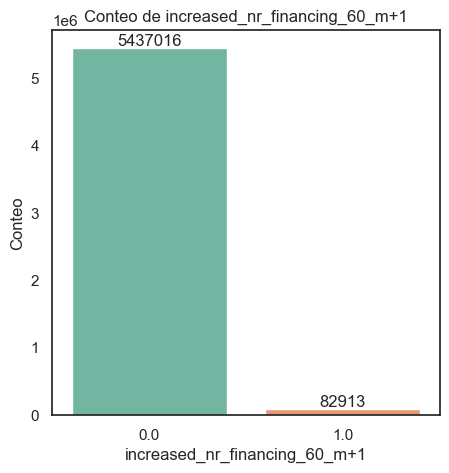

In [37]:
fig, (ax1) = plt.subplots(figsize=(5 , 5))

# df_temp = df_capstone_clean_4_without_last_partition.copy()
# df_temp['increased_products_m+1'].fillna('NaN', inplace=True) # no es necesario ya que llenamos los nulos anteriormente

counts = sns.countplot(data = df_capstone_clean_with_clusters_2_without_last_partition,
                        x= df_capstone_clean_with_clusters_2_without_last_partition[target],
                        #y= dataset[column].sort_values(),
                        order = df_capstone_clean_with_clusters_2_without_last_partition[target].value_counts(dropna=False).index,
                        palette='Set2')

for bars in counts.containers:
    counts.bar_label(bars, fmt = '%d');
    
#dis.set(xlabel = 'Conteo' , ylabel = column , title='Conteo de ' +  column);
counts.set(ylabel = 'Conteo' , xlabel = target , title='Conteo de ' +  target);

In [38]:
df_capstone_clean_with_clusters_2_without_last_partition[target].value_counts() / len(df_capstone_clean_with_clusters_2_without_last_partition[target]) * 100

increased_nr_financing_60_m+1
0.0    98.497934
1.0     1.502066
Name: count, dtype: float64

Como el dataset está muy desbalanceado, haremos un oversampling de la clase minoritaria más adelante

#### Imputer y Encoding

In [39]:
df_capstone_clean_with_clusters_2_without_last_partition.isnull().sum().sum()

0

In [40]:
df_capstone_clean_with_clusters_2_without_last_partition.columns

Index(['pk_cid', 'pk_partition', 'segment', 'increased_nr_financing_60_m+1',
       'age', 'months_from_last_purchase', 'nr_financing_60', 'nr_account_10',
       'nr_product_trend', 'customer_tenure', 'nr_transactions',
       'saving_behavior', 'risk_index_absolute', 'cluster', 'active_customer',
       'entry_date', 'regions_ca_id', 'nr_financing_60_trend', 'salary',
       'increased_nr_financing_60'],
      dtype='object')

In [41]:
# columnas a tratar con encoding

df_capstone_clean_with_clusters_2_without_last_partition.select_dtypes('O').columns

Index(['segment', 'regions_ca_id'], dtype='object')

In [42]:
def group_region_code_and_drop_columns(df):
    
    mapeo = {1.0: "PV", 2.0: "CM",  3.0: "VC",  4.0: "AN",  5.0: "CL",  6.0: "EX", 7.0: "IB",  8.0: "CT",  9.0: "CL", 10.0: "EX", 11.0: "AN", 
         12.0: "VC", 13.0: "CM", 14.0: "AN", 15.0: "GA", 16.0: "CM", 17.0: "CT", 18.0: "AN", 19.0: "CM", 20.0: "PV", 21.0: "AN", 22.0: "AR", 
         23.0: "AN", 24.0: "CL", 25.0: "CT", 26.0: "RI", 27.0: "GA", 28.0: "MD", 29.0: "AN", 30.0: "MC", 31.0: "NC", 32.0: "GA", 33.0: "AS", 34.0: "CL", 
         35.0: "CN", 36.0: "GA", 37.0: "CL", 38.0: "CN", 39.0: "CB", 40.0: "CL", 41.0: "AN",  42.0: "CL", 43.0: "CT", 44.0: "AR", 45.0: "CM", 46.0: "VC", 
         47.0: "CL", 48.0: "PV",  49.0: "CL", 50.0: "AR", 51.0: "CE", 52.0: "ML"}
    
    # df['regions_ca_id'] = df['region_code'].apply(lambda x: mapeo.get(float(x)) if x != 'Extranjero' else x)
    
    df.drop('region_code', axis='columns', inplace=True)
    df.drop('country_id', axis='columns', inplace=True)
    df.drop('regions_cluster', axis='columns', inplace=True)
    
    return df

In [43]:
group_region_code_function = FunctionTransformer(func = group_region_code_and_drop_columns)

In [44]:
def group_entry_channel_and_drop_columns(df):

    # # Categoría para RED
    # df.loc[df['entry_channel'] == 'RED', 'customer_acquisition_channel'] = 'RED'

    # # Categoría para valores numéricos
    # df.loc[df['entry_channel'].str.isnumeric(), 'customer_acquisition_channel'] = 'Numeric'

    # # Categorías por prefijo para el resto
    # df.loc[
    #     ~df['entry_channel'].isin(['RED']) & 
    #     ~df['entry_channel'].str.isnumeric(), 'customer_acquisition_channel'
    # ] = df['entry_channel'].str[:2]
    
    df.drop('entry_channel', axis='columns', inplace=True)
    df.drop('customer_acquisition_channel', axis='columns', inplace=True)
       
    return df

In [45]:
group_entry_channel_function = FunctionTransformer(func = group_entry_channel_and_drop_columns)

In [46]:
def pk_partition_month_extraction(df):
    
    # df['pk_partition_month'] = df['pk_partition'].dt.month_name()
    df.drop('pk_partition', axis='columns', inplace=True)
    
    return df

In [47]:
pk_partition_month_extraction_function = FunctionTransformer(func = pk_partition_month_extraction)

In [48]:
def convert_entry_date_to_numeric(df):
    
    df['entry_date'] = df['entry_date'].apply(lambda x: x.timestamp()).astype('int')
    
    return df

In [49]:
convert_entry_date_to_numeric_function = FunctionTransformer(func = convert_entry_date_to_numeric)

In [50]:
impute_pipe = ColumnTransformer(
        transformers = [
                    ("numeric_impute", SimpleImputer(strategy='constant', fill_value=-0), ['entry_channel_loyalty']),
                    # ("categorical_impute_1", SimpleImputer(strategy='constant', fill_value='accounts_debit_card'), ['most_popular_product'])
        ],
            remainder='passthrough',
            verbose_feature_names_out = False
)


In [51]:
segment_labels = [['03 - UNIVERSITARIO', '02 - PARTICULARES', '01 - TOP']]

encode_pipe = ColumnTransformer(
    transformers = [
            ("oe_cat", OneHotEncoder(sparse_output=False, dtype='int8', handle_unknown='ignore'), ['regions_ca_id', 'cluster']),
            ("orde_cat", OrdinalEncoder(categories=segment_labels), ['segment'])
        ],
    remainder='passthrough',
    verbose_feature_names_out = False
)


In [52]:
pipe = Pipeline(
    steps = [
        # ("group_region_code", group_region_code_function),                                                      #0
        # ("group_entry_channel", group_entry_channel_function),                                                  #1
        ("pk_partition_month_extraction", pk_partition_month_extraction_function),                              #2
        ("convert_entry_date_to_numeric", convert_entry_date_to_numeric_function),                              #3
        # ("imputer", impute_pipe),                                                                               #4
        ("encoder", encode_pipe),                                                                               #5
    ]
)

pipe

Pipeline(steps=[('pk_partition_month_extraction',
                 FunctionTransformer(func=<function pk_partition_month_extraction at 0x000002029DE7D1C0>)),
                ('convert_entry_date_to_numeric',
                 FunctionTransformer(func=<function convert_entry_date_to_numeric at 0x00000202CA45B240>)),
                ('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('oe_cat',
                                                  OneHotEncoder(dtype='int8',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['regions_ca_id', 'cluster']),
                                                 ('orde_cat',
                                                  OrdinalEncoder(categories=[['03 '
                                                                              '- '
                                                                              'UNIVERSITARIO',
                                                                              '02 '
                                                                              '- '
                                                                              'PARTICULARES',
                                                                              '01 '
                                                                              '- '
                                                                              'TOP']]),
                                                  ['segment'])],
                                   verbose_feature_names_out=False))])

In [53]:
# corremos el pipeline sobre el dataset

df_capstone_clean_with_clusters_2_without_last_partition_transformed_processed = df_capstone_clean_with_clusters_2_without_last_partition.copy()

df_capstone_clean_with_clusters_2_without_last_partition_transformed_processed = pipe.fit_transform(df_capstone_clean_with_clusters_2_without_last_partition_transformed_processed)

In [54]:
df_capstone_clean_with_clusters_2_without_last_partition_transformed_processed.columns

Index(['regions_ca_id_AN', 'regions_ca_id_AR', 'regions_ca_id_AS',
       'regions_ca_id_CB', 'regions_ca_id_CE', 'regions_ca_id_CL',
       'regions_ca_id_CM', 'regions_ca_id_CN', 'regions_ca_id_CT',
       'regions_ca_id_EX', 'regions_ca_id_Extranjero', 'regions_ca_id_GA',
       'regions_ca_id_IB', 'regions_ca_id_MC', 'regions_ca_id_MD',
       'regions_ca_id_ML', 'regions_ca_id_NC', 'regions_ca_id_PV',
       'regions_ca_id_RI', 'regions_ca_id_VC', 'cluster_-1.0', 'cluster_0.0',
       'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0',
       'cluster_5.0', 'cluster_6.0', 'segment', 'pk_cid',
       'increased_nr_financing_60_m+1', 'age', 'months_from_last_purchase',
       'nr_financing_60', 'nr_account_10', 'nr_product_trend',
       'customer_tenure', 'nr_transactions', 'saving_behavior',
       'risk_index_absolute', 'active_customer', 'entry_date',
       'nr_financing_60_trend', 'salary', 'increased_nr_financing_60'],
      dtype='object')

In [55]:
df_capstone_clean_with_clusters_2_without_last_partition_transformed_processed.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 5519929 entries, 0 to 5958709
Data columns (total 45 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   regions_ca_id_AN               5519929 non-null  int8   
 1   regions_ca_id_AR               5519929 non-null  int8   
 2   regions_ca_id_AS               5519929 non-null  int8   
 3   regions_ca_id_CB               5519929 non-null  int8   
 4   regions_ca_id_CE               5519929 non-null  int8   
 5   regions_ca_id_CL               5519929 non-null  int8   
 6   regions_ca_id_CM               5519929 non-null  int8   
 7   regions_ca_id_CN               5519929 non-null  int8   
 8   regions_ca_id_CT               5519929 non-null  int8   
 9   regions_ca_id_EX               5519929 non-null  int8   
 10  regions_ca_id_Extranjero       5519929 non-null  int8   
 11  regions_ca_id_GA               5519929 non-null  int8   
 12  regions_ca_id_IB   

In [56]:
df_capstone_clean_with_clusters_2_without_last_partition_transformed_processed.select_dtypes('O').columns

Index([], dtype='object')

In [57]:
# chequeo de nulos

print(df_capstone_clean_with_clusters_2_without_last_partition_transformed_processed.isnull().sum().sum())

0


In [58]:
# seteamos el id como index

df_capstone_clean_with_clusters_2_without_last_partition_transformed_processed.set_index('pk_cid', inplace=True)

In [59]:
df_capstone_clean_with_clusters_2_without_last_partition_transformed_processed.head().T

pk_cid,15891,15891,16063,16063,16063
regions_ca_id_AN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
regions_ca_id_AR,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
regions_ca_id_AS,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
regions_ca_id_CB,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
regions_ca_id_CE,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
regions_ca_id_CL,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
regions_ca_id_CM,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
regions_ca_id_CN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
regions_ca_id_CT,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
regions_ca_id_EX,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


### Oversampling de la clase minoritaria

[Undersampling and oversampling imbalanced data - Kaggle](https://www.kaggle.com/code/residentmario/undersampling-and-oversampling-imbalanced-data)

In [60]:
target = 'increased_nr_financing_60_m+1'
features = [i for i in df_capstone_clean_with_clusters_2_without_last_partition_transformed_processed.columns if i != target]

# Divide dataset en matriz de variables (X) y output (y)

X = df_capstone_clean_with_clusters_2_without_last_partition_transformed_processed[features]
y = df_capstone_clean_with_clusters_2_without_last_partition_transformed_processed[target]


In [61]:
ros = RandomOverSampler(random_state=42)

ros.fit(X, y)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [62]:
y_resampled.to_frame()['increased_nr_financing_60_m+1'].value_counts(dropna=False)

increased_nr_financing_60_m+1
0.0    5437016
1.0    5437016
Name: count, dtype: int64

In [63]:
X_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10874032 entries, 0 to 10874031
Data columns (total 43 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   regions_ca_id_AN           int8   
 1   regions_ca_id_AR           int8   
 2   regions_ca_id_AS           int8   
 3   regions_ca_id_CB           int8   
 4   regions_ca_id_CE           int8   
 5   regions_ca_id_CL           int8   
 6   regions_ca_id_CM           int8   
 7   regions_ca_id_CN           int8   
 8   regions_ca_id_CT           int8   
 9   regions_ca_id_EX           int8   
 10  regions_ca_id_Extranjero   int8   
 11  regions_ca_id_GA           int8   
 12  regions_ca_id_IB           int8   
 13  regions_ca_id_MC           int8   
 14  regions_ca_id_MD           int8   
 15  regions_ca_id_ML           int8   
 16  regions_ca_id_NC           int8   
 17  regions_ca_id_PV           int8   
 18  regions_ca_id_RI           int8   
 19  regions_ca_id_VC           int8   
 20  

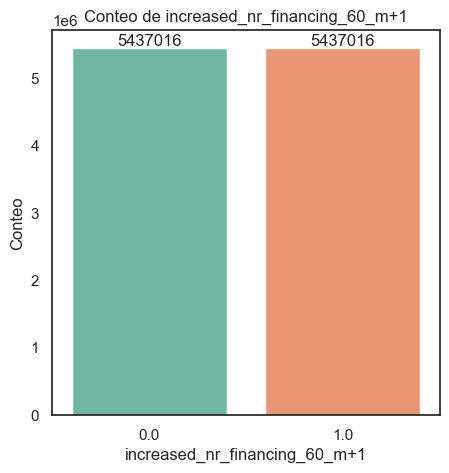

In [64]:
fig, (ax1) = plt.subplots(figsize=(5 , 5))

counts = sns.countplot(data = y_resampled.to_frame(),
                        x= y_resampled.to_frame()[target].sort_values(),
                        #y= dataset[column].sort_values(),
                        order = y_resampled.to_frame()[target].value_counts().index,
                        palette='Set2')

for bars in counts.containers:
    counts.bar_label(bars, fmt = '%d');
    
#dis.set(xlabel = 'Conteo' , ylabel = column , title='Conteo de ' +  column);
counts.set(ylabel = 'Conteo' , xlabel = target , title='Conteo de ' +  target);

El dataset ahora se encuentra balanceado en terminos de target

### Torneo de modelos

In [65]:
# Funcion que calcula el AUC de un modelo sobre un dataset (X-y). Args: modelo a validar, X, y
def auc(model,X,y):
  model.fit(X,y)
  return roc_auc_score(y,model.predict_proba(X)[:,1])

# Funcion que calcula el AUC en Cross-Validation (X-y). Args: modelo a validar, X, y
def auc_cross_validation(model,X,y):
  cross_val = cross_val_score(model,
                              X, y,
                              cv=4,                 # Numero de folds que vamos a utilizar para validar
                              scoring='roc_auc'     # La metrica de validacion que se medira en cada train-valida
                              )
  return cross_val.mean()

In [66]:
# Inicializa resultados
label_, auc_train_ , auc_valida_ = [], [], []

# Completa un registro en dataframe con los resultados de las funciones definidas previsamente (AUC y AUC con cross-validation)

# Inputs:
#   * modelo
#   * (X,y)
#   * label especifico si queremos registrar el resultado con otro nombre (opcional)


def evaluate_classification(model, X, y, label=None):
  if label is None:
    label=str(model)
  label_.append(label)

  auc_train = auc(model,X,y)
  auc_valida = auc_cross_validation(model,X,y)
  auc_train_.append(auc_train)
  auc_valida_.append(auc_valida)

  return pd.DataFrame({'Model': label_,
                      'AUC Train': auc_train_,
                      'AUC Cross-Valida': auc_valida_
                      }).sort_values('AUC Cross-Valida',ascending=False)

In [67]:
# esto no es correcto ya que hicimos el split en X e y junto con el oversample

# target = 'increased_products_m+1'
# features = [i for i in df_capstone_clean_4_without_last_partition_transformed_processed.columns if i != target]

# y = df_capstone_clean_4_without_last_partition_transformed_processed[target]
# X = df_capstone_clean_4_without_last_partition_transformed_processed[features]

In [68]:
# Random holdout con los X e y oversampled

X_train, X_test, y_train, y_test = train_test_split(
                                        X_resampled,        # usamos el dataframe con oversampling
                                        y_resampled,        # usamos el dataframe con oversampling
                                        test_size = 0.30, # tamaño del split aleatorio
                                        shuffle = True,
                                        stratify = y_resampled,
                                        random_state = 42
                                    )

In [69]:
print('Los datos X_train son ' + str(len(X_train)) + ' /'  + '{:.2%}'.format(len(X_train)/(len(X_train) + len(X_test))) + ' del total.')
print('Los datos y_train son ' + str(len(y_train)) + ' /'  + '{:.2%}'.format(len(y_train)/(len(y_train) + len(y_test))) + ' del total.')
print('Los datos X_test son ' + str(len(X_test)) + ' /'  + '{:.2%}'.format(len(X_test)/(len(X_train) + len(X_test))) + ' del total.')
print('Los datos y_test son ' + str(len(y_test)) + ' /'  + '{:.2%}'.format(len(y_test)/(len(y_train) + len(y_test))) + ' del total.')


Los datos X_train son 7611822 /70.00% del total.
Los datos y_train son 7611822 /70.00% del total.
Los datos X_test son 3262210 /30.00% del total.
Los datos y_test son 3262210 /30.00% del total.


In [70]:
print(X_train.shape)
print(y_train.shape)

(7611822, 43)
(7611822,)


In [71]:
# habría que estandarizar los datos al ser modelo de distancias?
# No creo que valga la pena sabiendo a priori que es un modelo de baja performance generalmente

# evaluate_classification(model = KNeighborsClassifier(),  X=X_train, y=y_train)

In [72]:
# habría que estandarizar los datos al ser modelo de distancias?
# No creo que valga la pena sabiendo a priori que es un modelo de baja performance generalmente

# evaluate_classification(model = LogisticRegression(), X=X, y=y)

In [73]:
# evaluate_classification(model = RandomForestClassifier(random_state = 42), X=X_train, y=y_train)

In [74]:
# evaluate_classification(model = XGBClassifier(random_state = 42, verbosity = 0), X=X_train, y=y_train)

In [75]:
# evaluate_classification(model = LGBMClassifier(verbose=0), X=X_train, y=y_train)

In [76]:
# evaluate_classification(model = DecisionTreeClassifier(random_state = 42),  X=X_train, y=y_train)

### Hiperparametrización

In [77]:
help(XGBClassifier)

Help on class XGBClassifier in module xgboost.sklearn:

class XGBClassifier(XGBModel, sklearn.base.ClassifierMixin)
 |  XGBClassifier(*, objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'binary:logistic', **kwargs: Any) -> None
 |  
 |  Implementation of the scikit-learn API for XGBoost classification.
 |  See :doc:`/python/sklearn_estimator` for more information.
 |  
 |  Parameters
 |  ----------
 |  
 |      n_estimators : Optional[int]
 |          Number of boosting rounds.
 |  
 |      max_depth :  Optional[int]
 |          Maximum tree depth for base learners.
 |      max_leaves :
 |          Maximum number of leaves; 0 indicates no limit.
 |      max_bin :
 |          If using histogram-based algorithm, maximum number of bins per feature
 |      grow_policy :
 |          Tree growing policy. 0: favor splitting at nodes closest to the node, i.e. grow
 |          depth-wise. 1: favor splitting at nodes with highest lo

In [78]:
# parameters = {'n_estimators':[50,100,150,200,250,300],
#               'max_depth':[2,3,4,5,6,7,8],
#               'max_leaves':[2,3,4,5,6,7,8],
#               'learning_rate':[0.01, 0.015, 0.02, 0.025, 0.03],
#               'booster':['gbtree', 'gblinear', 'dart'],
#               }           

In [79]:
# search_hp = RandomizedSearchCV(estimator = XGBClassifier(random_state = 42),
#                                param_distributions = parameters,
#                                scoring = 'roc_auc',     # metrica a optimizar: roc_auc
#                                cv = 4,                  # numero de folds para cross-validation
#                                n_iter = 5,              # numero de iteraciones, cada una testeara una configuracion distinta
#                                n_jobs=-1,
#                                verbose=True)

In [80]:
# search_hp.fit(X=X_train, y=y_train)

In [81]:
# print("---- Results from Random Search -----" )
# print("\n The best estimator across ALL searched params:", search_hp.best_estimator_)
# print("\n The best roc_auc:", search_hp.best_score_)
# print("\n The best parameters across ALL searched params:\n", search_hp.best_params_)

In [82]:
# la hiperparametrización da un peor modelo inicialmente, nos quedamos con el XGB a secas

# search_hp = RandomizedSearchCV(estimator = XGBClassifier(),
#                                param_distributions = {'random_state' : [42]},
#                                scoring = 'roc_auc',     # metrica a optimizar: roc_auc
#                                cv = 4,                  # numero de folds para cross-validation
#                                n_iter = 5,             # numero de iteraciones, cada una testeara una configuracion distinta
#                                n_jobs=2,
#                                verbose=True)

# search_hp.fit(X=X_train, y=y_train)

In [83]:
# print("---- Results from Random Search -----" )
# print("\n The best estimator across ALL searched params:", search_hp.best_estimator_)
# print("\n The best roc_auc:", search_hp.best_score_)
# print("\n The best parameters across ALL searched params:\n", search_hp.best_params_)

In [84]:
model = XGBClassifier(random_state = 42, verbosity = 0)

In [85]:
model.fit(X=X_train, y=y_train)
AUC_train = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])

print('El AUC en train es: ' + '{:.2%}'.format(AUC_train))

El AUC en train es: 95.96%


In [86]:
AUC_cross_val = cross_val_score(model,
                                X=X_train, y=y_train,
                                cv=4,                 # Numero de folds que vamos a utilizar para validar
                                scoring='roc_auc'     # La metrica de validacion que se medira en cada train-valida
                                )

print('El AUC en cross_validation es: ' + '{:.2%}'.format(AUC_cross_val.mean()))

El AUC en cross_validation es: 95.92%


[Introduction to Boosted Trees - XGBOOST](https://xgboost.readthedocs.io/en/stable/tutorials/model.html)

### Testeo del modelo

In [87]:
y_train_pred = model.predict(X_train)                        # predicciones del modelo en los datos de TRAIN
y_test_pred = model.predict(X_test)                          # predicciones del modelo en los datos de TEST

In [88]:
y_train_pred_proba = model.predict_proba(X_train)[:, 1]      # probabilidad de éxito (1) segun el modelo en los datos de TRAIN
y_test_pred_proba = model.predict_proba(X_test)[:, 1]        # probabilidad de éxito (1) segun el modelo en los datos de TEST

* AUC

In [89]:
auc_train = roc_auc_score(y_train, y_train_pred_proba)      # AUC en TRAIN
auc_test = roc_auc_score(y_test, y_test_pred_proba)         # AUC en TEST

In [90]:
print('AUC Train:', '{:.2%}'.format(round(auc_train,4)))
print('AUC Test:', '{:.2%}'.format(round(auc_test,4)))

AUC Train: 95.96%
AUC Test: 95.94%


* ROC Curve

In [91]:
# metrics for ROC

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

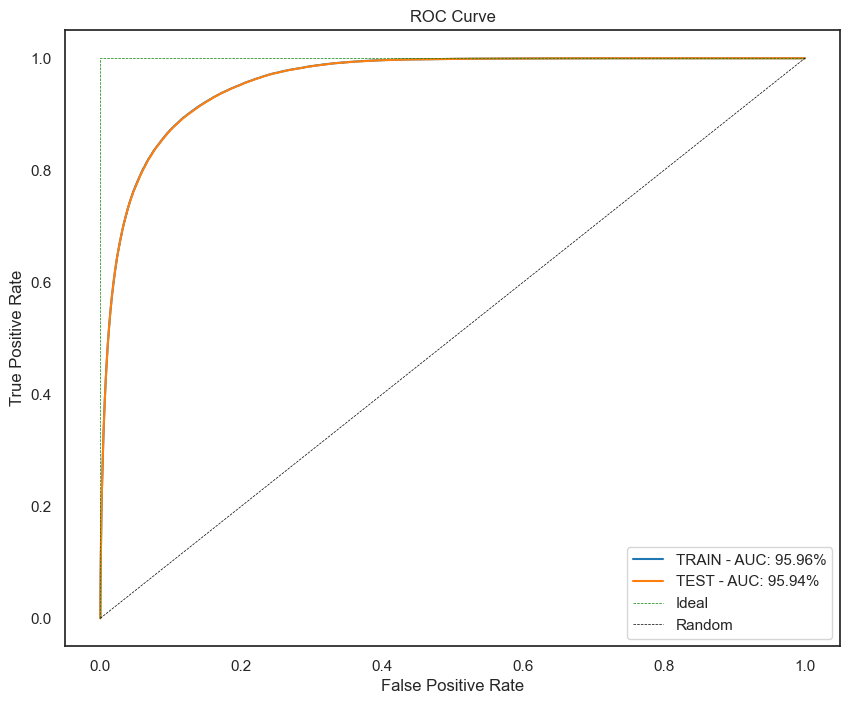

In [92]:
# Plot

plt.figure(figsize=[10,8])
plt.plot(fpr_train, tpr_train, label='TRAIN - AUC: {:.2%}'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='TEST - AUC: {:.2%}'.format(auc_test))
plt.title('ROC Curve')
plt.plot([0,0,1],[0,1,1], color='green', linestyle='--', linewidth=0.5, label='Ideal')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=0.5, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(False)
plt.show()

* Confusion Matrix

[]

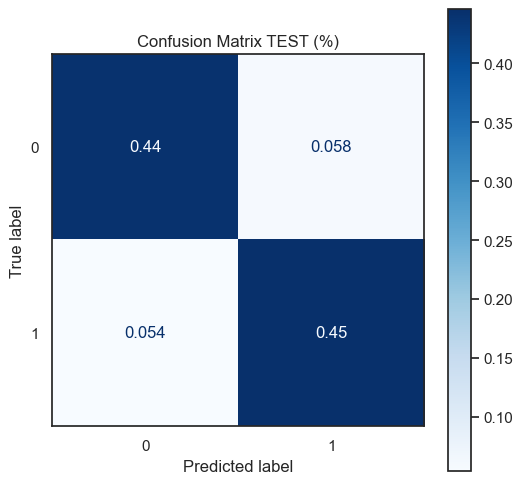

In [93]:
cm_test = confusion_matrix(y_test, y_test_pred)

f,ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay(confusion_matrix=cm_test/len(y_test)).plot(colorbar = True, cmap = 'Blues', ax=ax)
plt.title('Confusion Matrix TEST (%)')
plt.grid(False)
plt.plot()

* Accuracy, Precision, Recall y F1-Score

In [94]:
# metricas

print('Accuracy:', '{:.2%}'.format(round(accuracy_score(y_test, y_test_pred),4)))
print('Precision:', '{:.2%}'.format(round(precision_score(y_test, y_test_pred), 4)))
print('Recall:', '{:.2%}'.format(round(recall_score(y_test, y_test_pred), 4)))
print('F1-score:', '{:.2%}'.format(round(f1_score(y_test, y_test_pred), 4)))

Accuracy: 88.77%
Precision: 88.44%
Recall: 89.21%
F1-score: 88.82%


## Interpretabilidad

Los SHAP values nos indican ademas el sentido del impacto que tiene la variable en la predicción (positivo/negativo):
* Rojo a la derecha = POSITIVO (+)
* Rojo a la izquierda = NEGATIVO (-)

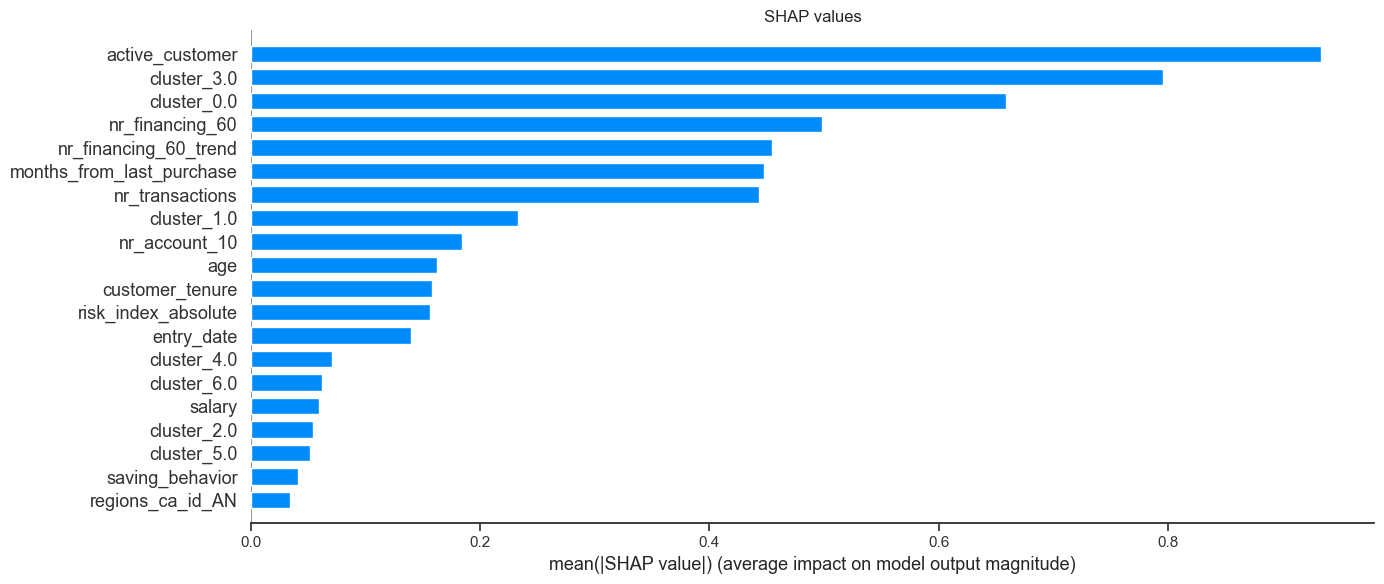

In [95]:
#SHAP value: peso en el output final

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
plt.title('SHAP values')
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20, plot_size=[14,6])

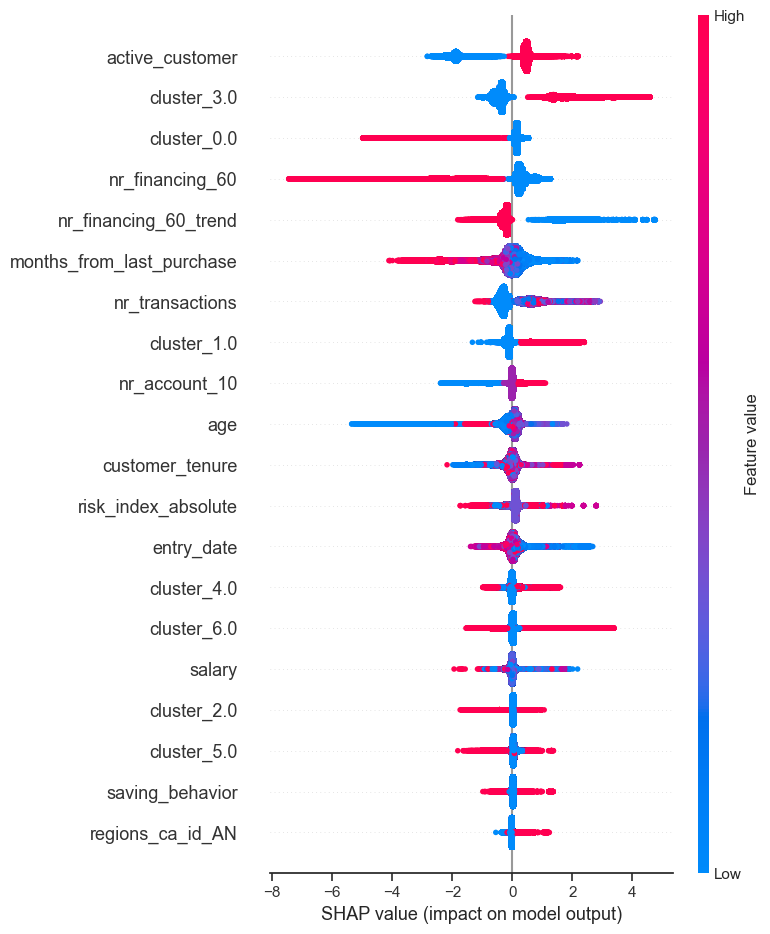

In [96]:
shap.summary_plot(shap_values, X_test, show = False)

In [97]:
lista_de_columnas_correlation_check =  ['pk_partition_month_April', 'pk_partition_month_August',
                                        'pk_partition_month_December', 'pk_partition_month_February',
                                        'pk_partition_month_January', 'pk_partition_month_July',
                                        'pk_partition_month_June', 'pk_partition_month_March',
                                        'pk_partition_month_May', 'pk_partition_month_November',
                                        'pk_partition_month_October', 'pk_partition_month_September',
                                         target]

In [98]:
# df_correlation_check = df_capstone_clean_with_clusters_2_without_last_partition_transformed_processed[lista_de_columnas_correlation_check]

In [99]:
# df_correlation_check.head().T

In [100]:
# plt.rcParams['figure.figsize'] = (20, 8)

# corr = df_correlation_check.corr(numeric_only=True)
# matrix = np.triu(corr)

# sns.heatmap(corr, annot=True, cmap="vlag", mask=matrix)
# plt.title('Heatmap de Correlación', fontsize = 10)
# plt.show()

## Guardado del modelo y pipeline

In [101]:
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD, 'classifier_propension')
PICKLE_PATH = os.path.join(DATA_PATH, 'classifier_propension_con_cluster_financing.pkl')

pickle.dump(model, open(PICKLE_PATH, 'wb'))

In [102]:
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD, 'classifier_propension')
PICKLE_PATH = os.path.join(DATA_PATH, 'pipeline_para_classifier_propension_con_cluster_financing.pkl')

pickle.dump(pipe, open(PICKLE_PATH, 'wb'))

## Predict

In [103]:
df_capstone_clean_with_clusters_2.columns

Index(['pk_cid', 'pk_partition', 'segment', 'increased_nr_financing_60_m+1',
       'age', 'months_from_last_purchase', 'nr_financing_60', 'nr_account_10',
       'nr_product_trend', 'customer_tenure', 'nr_transactions',
       'saving_behavior', 'risk_index_absolute', 'cluster', 'active_customer',
       'entry_date', 'regions_ca_id', 'nr_financing_60_trend', 'salary',
       'increased_nr_financing_60'],
      dtype='object')

In [104]:
# tomamos la última partición ya que sobre esta haremos el predict

df_capstone_clean_with_clusters_2_last_partition = df_capstone_clean_with_clusters_2[df_capstone_clean_with_clusters_2['pk_partition'] == '2019-05-28']

In [105]:
df_capstone_clean_with_clusters_2_last_partition_transformed_processed = df_capstone_clean_with_clusters_2_last_partition.copy()

df_capstone_clean_with_clusters_2_last_partition_transformed_processed = pipe.transform(df_capstone_clean_with_clusters_2_last_partition_transformed_processed)

In [106]:
df_capstone_clean_with_clusters_2_last_partition_transformed_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442995 entries, 8 to 5962923
Data columns (total 45 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   regions_ca_id_AN               442995 non-null  int8   
 1   regions_ca_id_AR               442995 non-null  int8   
 2   regions_ca_id_AS               442995 non-null  int8   
 3   regions_ca_id_CB               442995 non-null  int8   
 4   regions_ca_id_CE               442995 non-null  int8   
 5   regions_ca_id_CL               442995 non-null  int8   
 6   regions_ca_id_CM               442995 non-null  int8   
 7   regions_ca_id_CN               442995 non-null  int8   
 8   regions_ca_id_CT               442995 non-null  int8   
 9   regions_ca_id_EX               442995 non-null  int8   
 10  regions_ca_id_Extranjero       442995 non-null  int8   
 11  regions_ca_id_GA               442995 non-null  int8   
 12  regions_ca_id_IB               442

In [107]:
# seteamos el pk_cid como índice

df_capstone_clean_with_clusters_2_last_partition_transformed_processed.set_index('pk_cid', inplace=True)

In [108]:
X_pred = df_capstone_clean_with_clusters_2_last_partition_transformed_processed.copy()

In [109]:
print(model.feature_names_in_)

['regions_ca_id_AN' 'regions_ca_id_AR' 'regions_ca_id_AS'
 'regions_ca_id_CB' 'regions_ca_id_CE' 'regions_ca_id_CL'
 'regions_ca_id_CM' 'regions_ca_id_CN' 'regions_ca_id_CT'
 'regions_ca_id_EX' 'regions_ca_id_Extranjero' 'regions_ca_id_GA'
 'regions_ca_id_IB' 'regions_ca_id_MC' 'regions_ca_id_MD'
 'regions_ca_id_ML' 'regions_ca_id_NC' 'regions_ca_id_PV'
 'regions_ca_id_RI' 'regions_ca_id_VC' 'cluster_-1.0' 'cluster_0.0'
 'cluster_1.0' 'cluster_2.0' 'cluster_3.0' 'cluster_4.0' 'cluster_5.0'
 'cluster_6.0' 'segment' 'age' 'months_from_last_purchase'
 'nr_financing_60' 'nr_account_10' 'nr_product_trend' 'customer_tenure'
 'nr_transactions' 'saving_behavior' 'risk_index_absolute'
 'active_customer' 'entry_date' 'nr_financing_60_trend' 'salary'
 'increased_nr_financing_60']


In [110]:
features_pred = list(X_pred.columns)
features_model = list(model.feature_names_in_)

print('Columnas en dataset:',len(features_pred))
print('Variables en modelos:',len(features_model))
print('¿Match?:', features_model == features_pred)

Columnas en dataset: 44
Variables en modelos: 43
¿Match?: False


In [111]:
missing_features = [i for i in features_model if i not in features_pred]
exceeding_features = [i for i in features_pred if i not in features_model]
print('Variables que faltan en el dataset y hay que crear:\n', missing_features)
print('')
print('Variables que sobran en el dataset y hay que borrar:\n', exceeding_features)

Variables que faltan en el dataset y hay que crear:
 []

Variables que sobran en el dataset y hay que borrar:
 ['increased_nr_financing_60_m+1']


In [112]:
for col in missing_features:
  X_pred[col]= 0
  
X_pred.drop(columns = exceeding_features, inplace=True)

In [113]:
features_test = list(X_pred.columns)

print('Columnas en dataset:',len(features_test))
print('Variables en modelos:',len(features_model))
print('¿Match?:', features_model == features_test)

Columnas en dataset: 43
Variables en modelos: 43
¿Match?: True


In [114]:
# Reordena variables

X_pred = X_pred[features_model]

In [115]:
predictions = model.predict(X_pred)

In [116]:
predictions_proba = model.predict_proba(X_pred)

In [117]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [118]:
# probabilidad de increased_products_m+1 == 1

predictions_proba[:,1]

array([0.00232017, 0.14294769, 0.29988673, ..., 0.01756447, 0.06028235,
       0.02654664], dtype=float32)

In [119]:
df_capstone_clean_with_clusters_2_last_partition[target] = predictions

In [120]:
df_capstone_clean_with_clusters_2_last_partition[target + '_proba'] = predictions_proba[:,1]

In [121]:
df_capstone_clean_with_clusters_2_last_partition[[target]].head()

,increased_nr_financing_60_m+1
8,0
14,0
23,0
40,0
51,0


In [122]:
df_capstone_clean_with_clusters_2_last_partition.head().T

,8,14,23,40,51
pk_cid,16063,16203,16502,17457,17590
pk_partition,2019-05-28 00:00:00,2019-05-28 00:00:00,2019-05-28 00:00:00,2019-05-28 00:00:00,2019-05-28 00:00:00
segment,02 - PARTICULARES,01 - TOP,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES
increased_nr_financing_60_m+1,0,0,0,0,0
age,62,70,58,54,55
months_from_last_purchase,6,4,4,0,10
nr_financing_60,0,0,0,1,0
nr_account_10,0,1,2,1,0
nr_product_trend,0.0,0.0,0.0,1.0,0.0
customer_tenure,190,156,240,619,891


In [123]:
df_capstone_clean_with_clusters_2_last_partition[target].value_counts(dropna=False)

increased_nr_financing_60_m+1
0    407670
1     35325
Name: count, dtype: int64